In [1]:
import json
import os
import re
import warnings
from functools import lru_cache

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gensim.models import Word2Vec
from IPython.display import display
from nltk.corpus import stopwords
from pandarallel import pandarallel
from pymorphy3 import MorphAnalyzer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import (
    enable_halving_search_cv,  # noqa: F401, необходимо для использования экспериментальной функции
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


In [2]:
# Глобальные переменные
rstate = 42
os.environ["PYTHONWARNINGS"] = "ignore:pkg_resources is deprecated"
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

## 1. Скачиваем датасет

In [3]:
DATA_URL = "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz"
DATA_PATH = "lenta-ru-news.csv.gz"

if not os.path.exists(DATA_PATH):
    print(f"Файл {DATA_PATH} не найден, скачиваю из {DATA_URL}")
    response = requests.get(DATA_URL, stream=True, timeout=60)
    if response.status_code != 200:
        raise RuntimeError(f"Не удалось скачать датасет: HTTP {response.status_code}")
    with open(DATA_PATH, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Загрузка завершена")
else:
    print(f"Использем локальный файл {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print(df.info())
print()
print(df.head())


Использем локальный файл lenta-ru-news.csv.gz
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739351 entries, 0 to 739350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     739351 non-null  object
 1   title   739351 non-null  object
 2   text    739346 non-null  object
 3   topic   739148 non-null  object
 4   tags    712837 non-null  object
dtypes: object(5)
memory usage: 28.2+ MB
None

                                            url  \
0      https://lenta.ru/news/2018/12/14/cancer/   
1      https://lenta.ru/news/2018/12/15/doping/   
2  https://lenta.ru/news/2018/12/15/disneyland/   
3       https://lenta.ru/news/2018/12/15/usa25/   
4   https://lenta.ru/news/2018/12/15/integrity/   

                                               title  \
0  Названы регионы России с самой высокой смертно...   
1  Австрия не представила доказательств вины росс...   
2       Обнаружено самое счастливое место на планете   
3  В СШ

In [4]:
# Оставим только нужные колонки
df = df[["title", "text", "topic"]].copy()
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739351 entries, 0 to 739350
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   739351 non-null  object
 1   text    739346 non-null  object
 2   topic   739148 non-null  object
dtypes: object(3)
memory usage: 16.9+ MB
None

                                               title  \
0  Названы регионы России с самой высокой смертно...   
1  Австрия не представила доказательств вины росс...   
2       Обнаружено самое счастливое место на планете   
3  В США раскрыли сумму расходов на расследование...   
4  Хакеры рассказали о планах Великобритании зами...   

                                                text        topic  
0  Вице-премьер по социальным вопросам Татьяна Го...       Россия  
1  Австрийские правоохранительные органы не предс...        Спорт  
2  Сотрудники социальной сети Instagram проанализ...  Путешествия  
3  С начала расследования российского вмешательст

## 2. Предобработка данных

Исходные данные представляют собой высококачественный текст на русском языке. Данные уже были предварительно очищены от артефактов сбора. Источник данных - авторитетный новостной портал, стиль текста - информационный, разговорные сокращения, опечатки отсутсвуют.

-   Удаление строк с пропусками в `title`, `text` или `topic`.
-   Нормализация названий тем (нижний регистр, удаление пробелов).
-   Фильтрация редких тем (менее 10 вхождений) и удаление соответствующих записей.
-   *(Опционально)* Создание 20% стратифицированной по `topic` подвыборки.
-   Объединение `title` и `text` и их параллельная нормализация (лемматизация с `lru_cache`, удаление стоп-слов и не-букв).
-   Удаление пустых документов, появившихся после очистки.
-   Кодирование целевой переменной `topic` с помощью `LabelEncoder`.
-   Сохранение обработанного `DataFrame` (`.pkl`) и словаря `topic:id` (`.json`).
-   Разделяем выборку со стратификацией на тестовую (60%), тренировочную (20%) и валидационную (20%) подвыборки

In [5]:
# --- Исходные параметры ---
initial_rows = len(df)
sampling = True  # флаг запуска опционального сэмплирования

# --- 1. Очистка пропусков ---
df.dropna(subset=["title", "text", "topic"], inplace=True)
dropped_rows = initial_rows - len(df)
print(f"Удалено строк с пропусками: {dropped_rows} ({dropped_rows / initial_rows * 100:.2g} %)")

# --- 2. Очистка топиков ---
df["topic"] = df["topic"].str.lower().str.strip()

# --- 3. Отбрасываем редкие темы ---
min_samples = 10
topic_counts = df["topic"].value_counts()
topics_to_keep = topic_counts[topic_counts >= min_samples].index
topics_to_drop = topic_counts[topic_counts < min_samples].index
print(f"Список отброшенных тем: {list(topics_to_drop)}")

# Отбрасываем записи с редкими темами
df.drop(df[~df["topic"].isin(topics_to_keep)].index, inplace=True)
dropped_rare_rows = initial_rows - len(df)
print(
    f"Всего отброшено записей с редкими темами: {dropped_rare_rows}  ({dropped_rare_rows / initial_rows * 100:.2g} %)"
)

# --- 4. Сэмплирование 20% со стратификацией по теме ---
if sampling:
    sample_share = 0.2
    _, df_sample = train_test_split(df, test_size=sample_share, stratify=df["topic"], random_state=rstate)
    df = df_sample
    print(f"Размер стратифицированной подвыборки: {len(df)}")

# --- 5. Настройка нормализации ---

# Загружаем список стоп-слов, если нет в кэше
try:
    stopwords.words("russian")
except LookupError:
    nltk.download("stopwords")

russian_stopwords = set(stopwords.words("russian"))  # преобразуем к set для константного времени поиска
morph = MorphAnalyzer()
token_pattern = re.compile(r"[а-яёa-z]+", re.IGNORECASE)  # паттерн токена - только буквы алфавитов


# Функция лемматизации с кэшированием
@lru_cache(maxsize=100_000)
def lemmatize(token: str) -> str:
    parsed = morph.parse(token)[0]
    return parsed.normal_form


# Функция нормализации
def normalize_text(text: str) -> str:
    tokens = token_pattern.findall(text.lower())
    lemmas = (lemmatize(token) for token in tokens)
    cleaned = [lemma for lemma in lemmas if lemma not in russian_stopwords]
    return " ".join(cleaned)


# --- 6. Нормализация ---
print("Запуск нормализации текста...")
pandarallel.initialize(progress_bar=True, verbose=0)
temp_content_series = df["title"] + " " + df["text"]
df["content_clean"] = temp_content_series.parallel_apply(normalize_text)
df.drop(columns=["title", "text"], inplace=True)
print("Нормализация завершена.")

# --- 7. Очистка пустых документов ---
empty_docs_idx = df[df["content_clean"].str.len() == 0].index
df.drop(empty_docs_idx, inplace=True)
df.reset_index(drop=True, inplace=True)

# --- 8. Кодирование целевой переменной ---
label_encoder = LabelEncoder()
df["topic_encoded"] = label_encoder.fit_transform(df["topic"])

# --- 9. Сохранение результатов ---
print("Сохранение результатов...")

# 1. Сохраняем обработанный DataFrame
output_df_path = "processed_data.pkl"
df.to_pickle(output_df_path)

# 2. Создаем и сохраняем словарь закодированных тем
topic_to_id_map = {
    topic: int(idx)
    for topic, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_), strict=False)
}

output_map_path = "topic_to_id_map.json"
with open(output_map_path, "w", encoding="utf-8") as f:
    json.dump(topic_to_id_map, f, ensure_ascii=False, indent=4)

print(f"Обработанный DataFrame сохранен в: {output_df_path}")
print(f"Словарь 'topic: id' сохранен в: {output_map_path}")

Удалено строк с пропусками: 208 (0.028 %)
Список отброшенных тем: ['оружие', 'чм-2014', 'медновости', 'сочи']
Всего отброшено записей с редкими темами: 215  (0.029 %)
Размер стратифицированной подвыборки: 147828
Запуск нормализации текста...


Нормализация завершена.
Сохранение результатов...
Обработанный DataFrame сохранен в: processed_data.pkl
Словарь 'topic: id' сохранен в: topic_to_id_map.json


In [6]:
# Распаковываем сохраненные данные
df_path = "processed_data.pkl"
topic_to_id_map_path = "topic_to_id_map.json"

if "df" not in globals():  # загружаем только если переменной не существует
    df = pd.read_pickle(df_path)

if "topic_to_id_map" not in globals():  # загружаем только если переменной не существует
    with open(topic_to_id_map_path, encoding="utf-8") as f:
        topic_to_id_map = json.load(f)

# Разделяем данные на тренировочную (60%), тестовую (20%) и валидационную выборку (20%)
X = df["content_clean"]
y = df["topic"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=rstate,
    stratify=y,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=rstate,
    stratify=y_temp,
)

print("Размеры выборок:")
print(f"- тренировочной: {X_train.shape[0]}")
print(f"- тестовой: {X_test.shape[0]}")
print(f"- валидационной: {X_val.shape[0]}")

Размеры выборок:
- тренировочной: 88696
- тестовой: 29566
- валидационной: 29566


# 3. Базовая модель логистической регрессии

In [7]:
# Словарь конфигурации базовых векторизаторов
logreg_configs = {
    "CountVectorizer (default)": CountVectorizer(max_features=1000, ngram_range=(1, 1)),
    "TfidfVectorizer (default)": TfidfVectorizer(max_features=1000, ngram_range=(1, 1)),
}

# Структуры данных для сбора статистики
logreg_results = []
trained_pipelines = {}

# Обучаем и оцениваем каждую конфигурацию
for name, vectorizer in logreg_configs.items():
    # Конструируем пайплайн
    pipeline = Pipeline(
        [
            ("vectorizer", vectorizer),
            (
                "classifier",
                LogisticRegression(max_iter=500, solver="liblinear", C=1.0),
            ),
        ]
    )
    # Обучение модели
    pipeline.fit(X_train, y_train)

    # Предсказания и замер точности на тренировочной и валидационной выборке
    y_train_pred = pipeline.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    y_val_pred = pipeline.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Записываем результаты
    logreg_results.append(
        {
            "Модель": f"LogisticRegression + {name}",
            "Train accuracy": train_acc,
            "Val accuracy": val_acc,
        }
    )

    # Сохраняем модель
    trained_pipelines[name] = pipeline

    # Выводим краткую статистику
    print(f"{name}: train={train_acc:.4f} val={val_acc:.4f}")

# Выводим сравнительную таблицу по всем экспериментам
logreg_results_df = pd.DataFrame(logreg_results).sort_values("Val accuracy", ascending=False)
display(logreg_results_df)

CountVectorizer (default): train=0.7997 val=0.7666
TfidfVectorizer (default): train=0.7802 val=0.7649


,Модель,Train accuracy,Val accuracy
0,LogisticRegression + CountVectorizer (default),0.799664,0.766556
1,LogisticRegression + TfidfVectorizer (default),0.780170,0.764933


# 4. Оптимизация гиперпараметров

In [8]:
# Словарь конфигурации базовых векторизаторов
logreg_tune_configs = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
}

# Сетки параметров
param_grids = {
    "CountVectorizer": {
        "vectorizer__ngram_range": [(1, 1), (1, 2)],
        "vectorizer__max_features": [300, 1000],
        "vectorizer__min_df": [1, 2],
        "classifier__penalty": ["l1"],
        "classifier__C": [0.5, 1.0],
    },
    "TfidfVectorizer": {
        "vectorizer__ngram_range": [(1, 1), (1, 2)],
        "vectorizer__max_features": [300, 1000],
        "vectorizer__min_df": [1, 2],
        "classifier__penalty": ["l1"],
        "classifier__C": [0.5, 1.0],
    },
}

for name, vectorizer in logreg_tune_configs.items():
    # Конструируем пайпланы
    pipeline = Pipeline(
        [
            ("vectorizer", vectorizer),
            (
                "classifier",
                LogisticRegression(
                    max_iter=500,
                    solver="liblinear",
                    random_state=42,
                ),
            ),
        ]
    )

    # Выбираем сетку параметров для текущего пайплайна
    current_param_grid = param_grids[name]

    # Запускаем подбор гиперпараметров
    grid_search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=current_param_grid,
        cv=3,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0,
    )
    grid_search.fit(X_train, y_train)
    best_pipeline = grid_search.best_estimator_

    # Считаем метрики для лучшей модели
    y_train_pred = best_pipeline.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    y_val_pred = best_pipeline.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Формируем имя с суффиксом (tuned)
    model_name = f"LogisticRegression + {name} (tuned)"

    # Записываем результаты
    logreg_results.append(
        {
            "Модель": model_name,
            "Train accuracy": train_acc,
            "Val accuracy": val_acc,
        }
    )

    # Сохраняем модель
    trained_pipelines[model_name] = best_pipeline

    # Выводим краткую статистику
    print(f"{model_name}: train={train_acc:.4f}, val={val_acc:.4f}")

# Выводим сравнительную таблицу по всем экспериментам
logreg_results_df = pd.DataFrame(logreg_results).sort_values("Val accuracy", ascending=False)
display(logreg_results_df)

LogisticRegression + CountVectorizer (tuned): train=0.7953, val=0.7675
LogisticRegression + TfidfVectorizer (tuned): train=0.7850, val=0.7700


,Модель,Train accuracy,Val accuracy
3,LogisticRegression + TfidfVectorizer (tuned),0.784951,0.770040
2,LogisticRegression + CountVectorizer (tuned),0.795323,0.767503
0,LogisticRegression + CountVectorizer (default),0.799664,0.766556
1,LogisticRegression + TfidfVectorizer (default),0.780170,0.764933


# 5. Обучение Word2Vec эмбеддингов

### Выбор гиперпараметров
-  **Размер векторов = 100**. Корпус текста относительно небольшой, поэтому выберем вектора маленького размера. Классическое значение 100-300.
-  **Размер окна = 5**. Текст в корпусе связный, предложения стандартной и большой длины. Выберем стандартное окно - 5.
-  **Минимальная частота слова = 10**. На этапе предподготовки самые частотные стоп-слова отбросили. Преплолагаем, что могли остатьсяф слова, являющиеся шумом - поэтому пример 10 как минимальную частоту слова.

In [9]:
# 1. Подготовка данных для Gensim
sentences_for_w2v = [text.split() for text in X_train]

# 2. Определение гиперпараметров
vector_size = 100
window_size = 5
min_word_count = 10
skip_gram = 1

num_workers = os.cpu_count()
epochs = 10

# 3. Обучение модели
w2v_model = Word2Vec(
    sentences=sentences_for_w2v,
    vector_size=vector_size,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sg=skip_gram,
    epochs=epochs,
    seed=rstate,
)

# 4. Внутренняя оценка качества

# 4.1. Тест most_similar (поиск похожих слов)
print("\n--- Тест most_similar ---")

# Набор тестовых слов
test_words = ["автомобиль", "россия", "нефть", "школа"]

for word in test_words:
    if word in w2v_model.wv:
        print(f"\nСлова, похожие на '{word}':")
        print(w2v_model.wv.most_similar(word, topn=5))
    else:
        print(f"\nСлово '{word}' отсутствует в словаре (vстретилось < {min_word_count} раз).")

# 4.2. Тест doesnt_match (поиск лишнего слова)
test_sets = [
    ["россия", "сша", "китай", "рубль"],
    ["футбол", "хоккей", "баскетбол", "политика"],
    ["учитель", "врач", "инженер", "автомобиль"],
]

print("\n--- Тест 'лишнее слово' (doesnt_match) ---")
for s in test_sets:
    words_in_vocab = [w for w in s if w in w2v_model.wv]

    if len(words_in_vocab) < len(s):
        print(f"Невозможно провести тест для {s}, т.к. не все слова есть в словаре.")
    else:
        outlier = w2v_model.wv.doesnt_match(words_in_vocab)
        print(f"В списке {words_in_vocab} лишнее слово:  {outlier}")

# 4.3. Тест на семантические аналогии (классический "король - мужчина + женщина = королева")
print("\n--- Тест на аналогии ('король - мужчина + женщина') ---")
analogy_query_words = ["король", "женщина", "мужчина"]

if all(w in w2v_model.wv for w in analogy_query_words):
    # Ищем: (король + женщина) - мужчина = ? (ожидаем "королева")
    result = w2v_model.wv.most_similar(positive=["король", "женщина"], negative=["мужчина"], topn=3)
    print(f"король - мужчина + женщина = {result}")


--- Тест most_similar ---

Слова, похожие на 'автомобиль':
[('машина', 0.8893619775772095), ('внедорожник', 0.8710676431655884), ('легковой', 0.854045033454895), ('bmw', 0.8263870477676392), ('автомашина', 0.8013293147087097)]

Слова, похожие на 'россия':
[('рф', 0.7354313135147095), ('российский', 0.6633370518684387), ('белоруссия', 0.6588283181190491), ('страна', 0.6310269236564636), ('украина', 0.5907572507858276)]

Слова, похожие на 'нефть':
[('баррель', 0.8634528517723083), ('нефтепродукт', 0.8256097435951233), ('сырьё', 0.8094436526298523), ('углеводород', 0.7922011613845825), ('нефтяной', 0.7837638854980469)]

Слова, похожие на 'школа':
[('учиться', 0.8008085489273071), ('общеобразовательный', 0.7993735074996948), ('гимназия', 0.7900208234786987), ('ученик', 0.7813354730606079), ('преподаватель', 0.7698528170585632)]

--- Тест 'лишнее слово' (doesnt_match) ---
В списке ['россия', 'сша', 'китай', 'рубль'] лишнее слово:  рубль
В списке ['футбол', 'хоккей', 'баскетбол', 'политика'

### **ВЫВОД**: 

В общем и целом оценки удовлетворительные (за исключение теста на аналогии), можно считать, что вектора обладают заданными свойствами

# 6. Загрузка предобученных эмбеддингов

Выберем большую модель, обученную на Национальном корпусе русского языка.

In [10]:
import gensim.downloader as api

# Загрузка модели
model_name = "word2vec-ruscorpora-300"
model = api.load(model_name)


# Тест most_similar (поиск похожих слов)
print("\n--- Тест most_similar ---")

# Тестовый словарь POS-тегами
test_words = ["президент_NOUN", "идти_VERB"]

for word in test_words:
    if word in model:
        print(f"\nСлово: '{word}'")

        # Получение вектора
        vector = model[word]

        # Поиск похожих слов
        # P.S. Похожие слова также будут возвращаться с POS-тегами
        similar = model.most_similar(word, topn=5)

        print(f"  Похожие слова: {similar}")
    else:
        print(f"\nСлово '{word}' отсутствует в словаре.")

# --- Тест 'лишнее слово' (doesnt_match) ---

# Адаптируем тестовые наборы, добавив POS-теги
test_sets = [
    ["россия_NOUN", "сша_NOUN", "китай_NOUN", "рубль_NOUN"],
    ["футбол_NOUN", "хоккей_NOUN", "баскетбол_NOUN", "политика_NOUN"],
    ["учитель_NOUN", "врач_NOUN", "инженер_NOUN", "автомобиль_NOUN"],
    ["бежать_VERB", "прыгать_VERB", "читать_VERB", "стол_NOUN"],
]

print("\n--- Тест 'лишнее слово' (doesnt_match) ---")
for s in test_sets:
    # Проверяем, что все слова есть в словаре модели
    words_in_vocab = [w for w in s if w in model]

    if len(words_in_vocab) < len(s):
        missing = set(s) - set(words_in_vocab)
        print(f"\nНевозможно провести тест для {s}, т.к. слова {missing} отсутствуют в словаре.")
    else:
        # Используем 'model'
        outlier = model.doesnt_match(words_in_vocab)
        print(f"\nВ списке {words_in_vocab} лишнее слово:  {outlier}")


# --- Тест 3: Семантические аналогии ---
print("\n--- Тест на аналогии ('король - мужчина + женщина') ---")

positive_words = ["король_NOUN", "женщина_NOUN"]
negative_words = ["мужчина_NOUN"]

analogy_query_words = positive_words + negative_words

# Проверяем, что все слова есть в 'model'
if all(w in model for w in analogy_query_words):
    result = model.most_similar(positive=positive_words, negative=negative_words, topn=3)
    print(f"король_NOUN - мужчина_NOUN + женщина_NOUN = {result}")
else:
    missing = [w for w in analogy_query_words if w not in model]
    print(f"Невозможно провести тест на аналогии, т.к. слова {missing} отсутствуют в словаре.")


--- Тест most_similar ---

Слово: 'президент_NOUN'
  Похожие слова: [('путин_NOUN', 0.772294819355011), ('президентский_ADJ', 0.7611932754516602), ('ельцин_NOUN', 0.701576828956604), ('премьер-министр_NOUN', 0.6987968683242798), ('татарстан::минтимер_NOUN', 0.6845797300338745)]

Слово: 'идти_VERB'
  Похожие слова: [('пойти_VERB', 0.7285876274108887), ('брести_VERB', 0.5698232650756836), ('плестись_VERB', 0.5263214111328125), ('шагать_VERB', 0.5238107442855835), ('тащиться_VERB', 0.5215544104576111)]

--- Тест 'лишнее слово' (doesnt_match) ---

В списке ['россия_NOUN', 'сша_NOUN', 'китай_NOUN', 'рубль_NOUN'] лишнее слово:  рубль_NOUN

В списке ['футбол_NOUN', 'хоккей_NOUN', 'баскетбол_NOUN', 'политика_NOUN'] лишнее слово:  политика_NOUN

В списке ['учитель_NOUN', 'врач_NOUN', 'инженер_NOUN', 'автомобиль_NOUN'] лишнее слово:  автомобиль_NOUN

В списке ['бежать_VERB', 'прыгать_VERB', 'читать_VERB', 'стол_NOUN'] лишнее слово:  стол_NOUN

--- Тест на аналогии ('король - мужчина + женщина')

### **ВЫВОД**: 

Модель справилась с тестами без единого замечания - сказывается размер и качество корпуса для обучения.

# 7. LogReg на эмбеддингах

In [11]:
# --- Подготовка к обучению ---


class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Преобразует список текстов в матрицу усредненных Word2Vec векторов.

    Является трансформером, совместимым с `sklearn.pipeline.Pipeline`.
    Предполагает, что на вход подаются уже очищенные и
    токенезированные по словам тексты, соединенные пробелами.

    Parameters
    ----------
    w2v_model : gensim.models.Word2Vec or gensim.models.KeyedVectors
        Обученная модель Word2Vec (или только ее KeyedVectors,
        например, w2v_model.wv).

    use_pos_stripping : bool, default=False
        Определяет стратегию поиска векторов:
        - False: Ожидается, что слова в тексте (e.g., "кошка") точно
          соответствуют ключам в `w2v_model`.
        - True: Используется для pre-trained моделей с POS-тегами
          (e.g., "кошка_NOUN"). Векторизатор будет пытаться найти
          слово, автоматически подставляя теги (_NOUN, _ADJ, _VERB, _ADV).

    Attributes
    ----------
    vector_size : int
        Размерность векторов в предоставленной `w2v_model`.

    vocab : dict
        Словарь (key_to_index) модели.

    vector_lookup : gensim.models.KeyedVectors
        Объект для поиска векторов (обычно `w2v_model.wv` или сама
        `w2v_model`, если это KeyedVectors).
    """

    def __init__(self, w2v_model, use_pos_stripping=False):
        self.w2v_model = w2v_model
        self.use_pos_stripping = use_pos_stripping

        # Определяем размерность вектора из модели
        if hasattr(self.w2v_model, "wv"):
            self.vector_size = self.w2v_model.wv.vector_size
        else:
            self.vector_size = self.w2v_model.vector_size

    def fit(self, X, y=None):
        # Не имплементирован, модели обучены предварительно.
        # Добавлен для совместимости интерфейсов.
        return self

    def transform(self, X):
        """
        Преобразует X (список текстов) в матрицу NumPy.
        """
        mean_vectors = []

        # Определяем, где находится словарь (в .wv или напрямую)
        vocab = self.w2v_model.wv.key_to_index if hasattr(self.w2v_model, "wv") else self.w2v_model.key_to_index
        vector_lookup = self.w2v_model.wv if hasattr(self.w2v_model, "wv") else self.w2v_model

        for text in X:
            words = text.split()
            word_vectors = []

            if not self.use_pos_stripping:
                # Поиск слова для модели без POS-тегов
                word_vectors = [vector_lookup[word] for word in words if word in vocab]

            else:
                # Поиск слова для модели с POS-тегом
                for word in words:
                    found_vec = None
                    # Пробуем найти слово подставляя к нему POS-теги в порядке приоритета
                    for pos in ["_NOUN", "_ADJ", "_VERB", "_ADV"]:
                        tagged_word = word + pos
                        if tagged_word in vocab:
                            found_vec = vector_lookup[tagged_word]
                            break

                    if found_vec is not None:  # Если не нашли - просто пропускаем слово
                        word_vectors.append(found_vec)

            if not word_vectors:  # noqa: SIM108, замена на тернарный оператор ухудшит выразительность
                mean_vec = np.zeros(self.vector_size)
            else:
                # Усредняем векторы
                mean_vec = np.mean(word_vectors, axis=0)

            mean_vectors.append(mean_vec)

        return np.array(mean_vectors)


# --- Обучение ---

# Словарь конфигурации
logreg_configs = {
    "Word2Vec (Self-Trained, Mean)": Word2VecVectorizer(w2v_model, use_pos_stripping=False),
    "Word2Vec (Pre-Trained, Mean, POS-Hack)": Word2VecVectorizer(model, use_pos_stripping=True),
}
# Обучаем и оцениваем
for name, vectorizer in logreg_configs.items():
    # Конструируем пайплайн
    pipeline = Pipeline(
        [
            ("vectorizer", vectorizer),
            (
                "classifier",
                LogisticRegression(max_iter=500, solver="liblinear", C=1.0, random_state=rstate),
            ),
        ]
    )

    # Обучение модели
    pipeline.fit(X_train, y_train)

    # Предсказания и замер точности
    y_train_pred = pipeline.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    y_val_pred = pipeline.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Записываем результаты
    logreg_results.append(
        {
            "Модель": f"LogisticRegression + {name}",
            "Train accuracy": train_acc,
            "Val accuracy": val_acc,
        }
    )

    # Сохраняем модель
    trained_pipelines[name] = pipeline

    # Выводим краткую статистику
    print(f"{name}: train={train_acc:.4f} val={val_acc:.4f}")

# Выводим сравнительную таблицу
print("\n--- Обновленная сравнительная таблица ---")
logreg_results_df = pd.DataFrame(logreg_results).sort_values("Val accuracy", ascending=False)

display(logreg_results_df)

Word2Vec (Self-Trained, Mean): train=0.7862 val=0.7798
Word2Vec (Pre-Trained, Mean, POS-Hack): train=0.7469 val=0.7400

--- Обновленная сравнительная таблица ---


,Модель,Train accuracy,Val accuracy
4,"LogisticRegression + Word2Vec (Self-Trained, M...",0.786168,0.779781
3,LogisticRegression + TfidfVectorizer (tuned),0.784951,0.770040
2,LogisticRegression + CountVectorizer (tuned),0.795323,0.767503
0,LogisticRegression + CountVectorizer (default),0.799664,0.766556
1,LogisticRegression + TfidfVectorizer (default),0.780170,0.764933
5,"LogisticRegression + Word2Vec (Pre-Trained, Me...",0.746866,0.739972


# 8. Сравнение всех моделей на тестовой части выборки

In [12]:
# Структура для хранения результатов
results_list = []

# Словарь с выборками для итерации
datasets_to_evaluate = {"train": (X_train, y_train), "validation": (X_val, y_val), "test": (X_test, y_test)}

# Внешний цикл: по моделям
for model_name, pipeline in trained_pipelines.items():
    # Внутренний цикл: по выборкам (train, val, test)
    for dataset_name, (X_data, y_data) in datasets_to_evaluate.items():
        # Получаем предсказания
        y_pred = pipeline.predict(X_data)

        # Считаем метрики (weighted)
        accuracy = accuracy_score(y_data, y_pred)
        precision = precision_score(y_data, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_data, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_data, y_pred, average="weighted", zero_division=0)

        # Добавляем в список
        results_list.append(
            {
                "model_name": model_name,
                "dataset": dataset_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_weighted": f1,
            }
        )

# Создаем DataFrame и разворачиваем его в сводную таблицу
results_df = pd.DataFrame(results_list)
final_summary_df = results_df.pivot_table(
    index="model_name", columns="dataset", values=["accuracy", "precision", "recall", "f1_weighted"]
)

# Улучшаем читаемость таблицы:
#    - Меняем уровни колонок (сначала 'dataset', потом 'metric')
#    - Сортируем колонки в логическом порядке (train, validation, test)
#    - Сортируем модели по F1-мере на тесте (от лучшей к худшей)

final_summary_df = final_summary_df.swaplevel(0, 1, axis=1)
final_summary_df = final_summary_df.reindex(columns=["train", "validation", "test"], level=0)

# Сортировка по F1-мере на тестовой выборке
final_summary_df = final_summary_df.sort_values(by=("test", "f1_weighted"), ascending=False)

# Выводим сводный результат
display(final_summary_df)

dataset                                          train                        \
                                              accuracy f1_weighted precision   
model_name                                                                     
Word2Vec (Self-Trained, Mean)                 0.786168    0.774507  0.776239   
LogisticRegression + CountVectorizer (tuned)  0.795323    0.791378  0.794680   
CountVectorizer (default)                     0.799664    0.796434  0.798798   
LogisticRegression + TfidfVectorizer (tuned)  0.784951    0.778179  0.782328   
TfidfVectorizer (default)                     0.780170    0.771928  0.778788   
Word2Vec (Pre-Trained, Mean, POS-Hack)        0.746866    0.727384  0.735287   

dataset                                                validation              \
                                                recall   accuracy f1_weighted   
model_name                                                                      
Word2Vec (Self-Trained, Mean)                 0.786168   0.779781    0.768109   
LogisticRegression + CountVectorizer (tuned)  0.795323   0.767503    0.762225   
CountVectorizer (default)                     0.799664   0.766556    0.761932   
LogisticRegression + TfidfVectorizer (tuned)  0.784951   0.770040    0.763027   
TfidfVectorizer (default)                     0.780170   0.764933    0.756051   
Word2Vec (Pre-Trained, Mean, POS-Hack)        0.746866   0.739972    0.720026   

dataset                                                               test  \
                                             precision    recall  accuracy   
model_name                                                                   
Word2Vec (Self-Trained, Mean)                 0.771038  0.779781  0.784685   
LogisticRegression + CountVectorizer (tuned)  0.763334  0.767503  0.769025   
CountVectorizer (default)                     0.762668  0.766556  0.767233   
LogisticRegression + TfidfVectorizer (tuned)  0.765611  0.770040  0.769905   
TfidfVectorizer (default)                     0.759024  0.764933  0.766286   
Word2Vec (Pre-Trained, Mean, POS-Hack)        0.728698  0.739972  0.745146   

dataset                                                                       
                                             f1_weighted precision    recall  
model_name                                                                    
Word2Vec (Self-Trained, Mean)                   0.772467  0.773962  0.784685  
LogisticRegression + CountVectorizer (tuned)    0.763170  0.764847  0.769025  
CountVectorizer (default)                       0.761968  0.762917  0.767233  
LogisticRegression + TfidfVectorizer (tuned)    0.761679  0.764521  0.769905  
TfidfVectorizer (default)                       0.756598  0.761415  0.766286  
Word2Vec (Pre-Trained, Mean, POS-Hack)          0.724837  0.732899  0.745146

## 8.1 Сводные результаты в графической форме

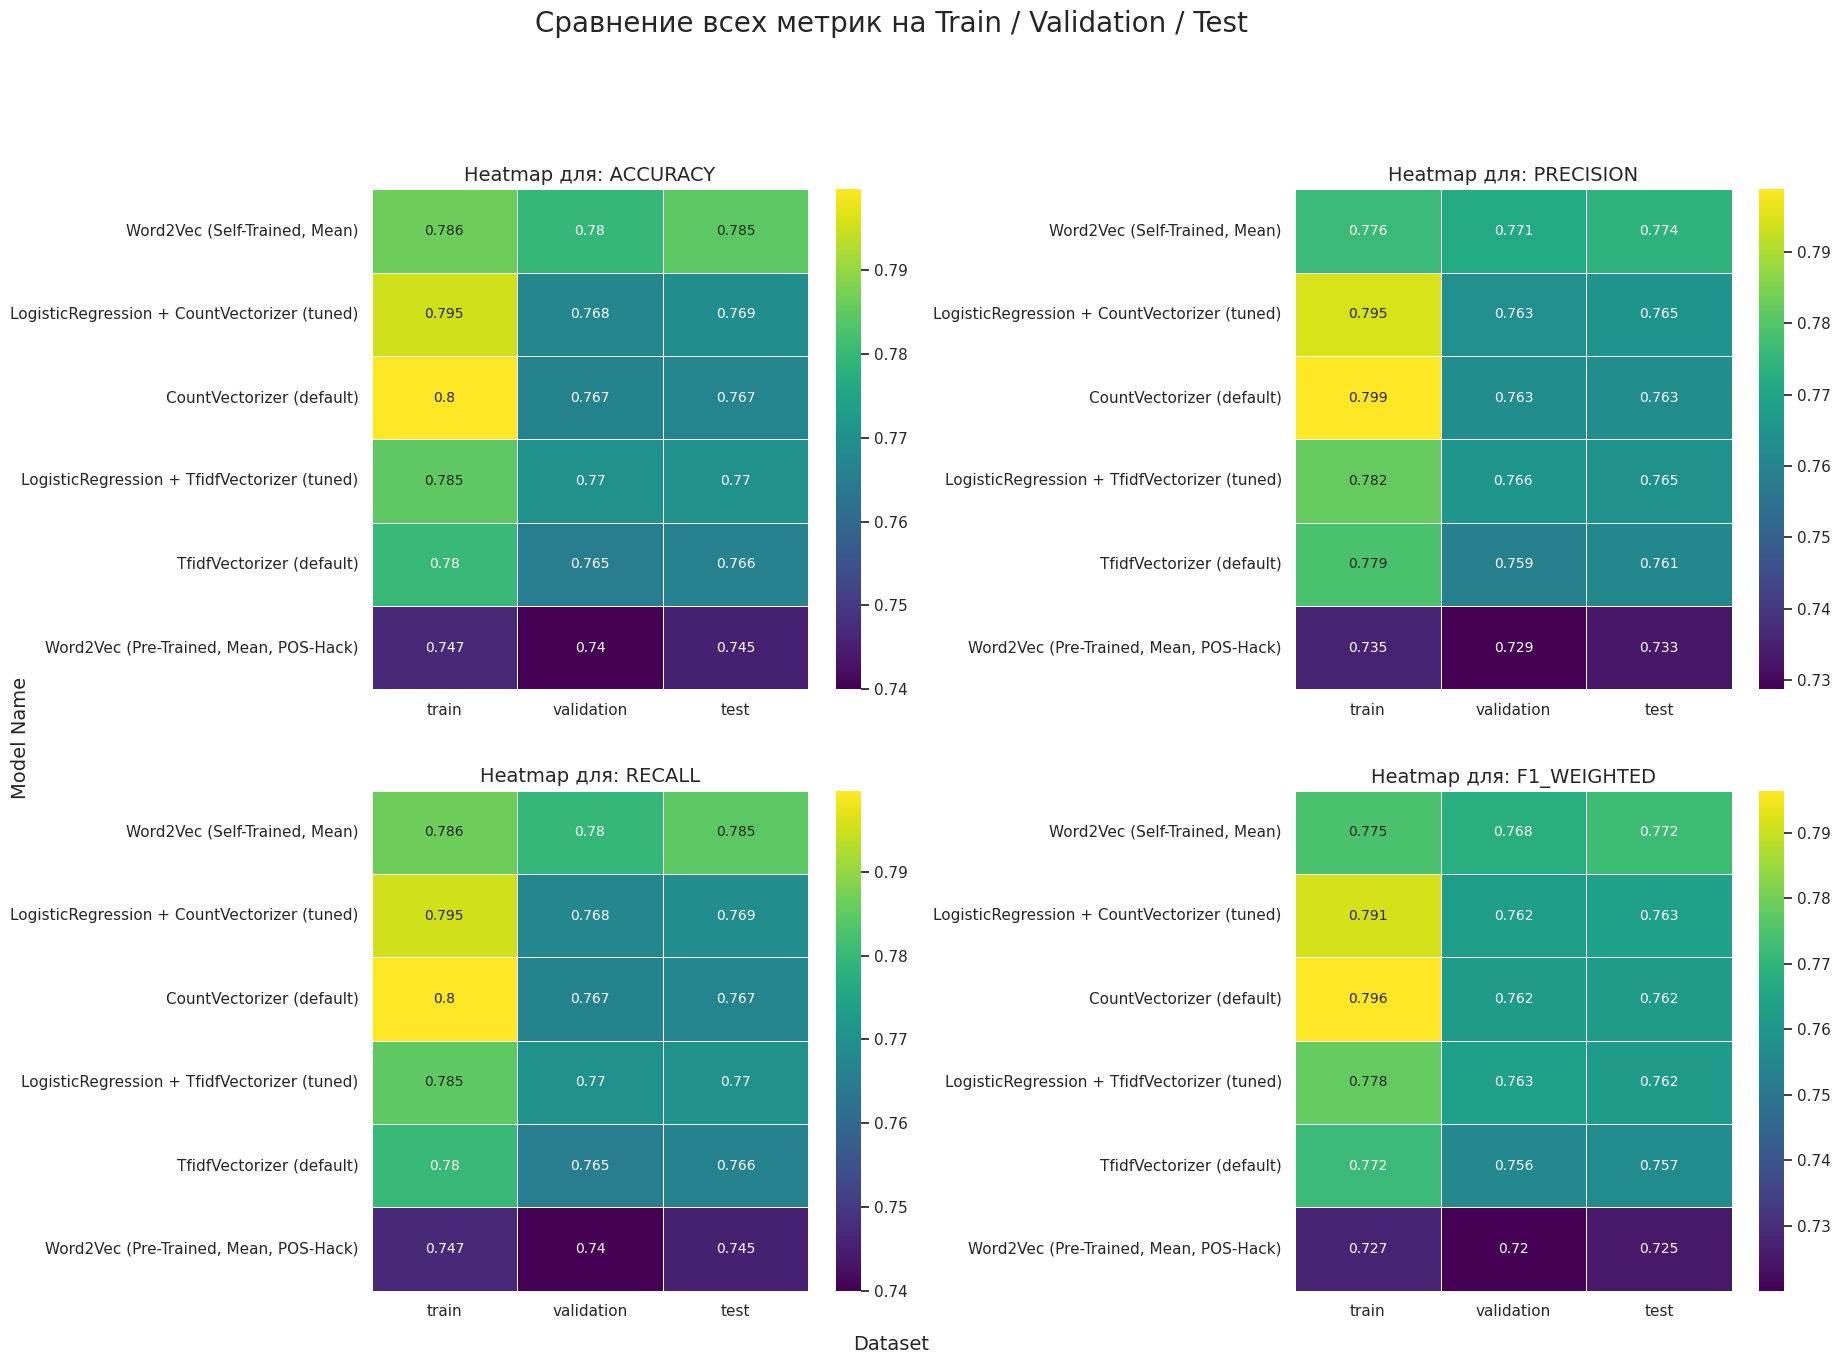

In [13]:
sns.set_theme(style="white")
metrics_to_plot = ["accuracy", "precision", "recall", "f1_weighted"]

# Создаем сетку 2x2
fig, axs = plt.subplots(2, 2, figsize=(20, 14))
axs = axs.flatten()  # Выравниваем массив для удобной итерации

# Строим четыре графика
for i, metric in enumerate(metrics_to_plot):
    ax = axs[i]
    metric_data = final_summary_df.loc[:, (slice(None), metric)]

    # Упрощаем названия колонок (e.g., ('train', 'accuracy') -> 'train')
    metric_data.columns = metric_data.columns.get_level_values(0)
    metric_data.columns.name = "Dataset"

    # Отображаем график
    sns.heatmap(
        metric_data,
        annot=True,
        fmt=".3g",
        cmap="viridis",
        linewidths=0.5,
        ax=ax,
        annot_kws={"size": 10},
    )

    # Настройки subplot
    ax.set_title(f"Heatmap для: {metric.upper()}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="y", rotation=0)

# Настройки холста
fig.supxlabel("Dataset", fontsize=14, y=0.06)
fig.supylabel("Model Name", fontsize=14, x=0.06)
fig.suptitle("Сравнение всех метрик на Train / Validation / Test", fontsize=20, y=1.02)
plt.tight_layout(pad=3.0)

plt.show()

# ВЫВОДЫ:

* **Модели на основе BoW (`CountVectorizer`, `TfidfVectorizer`):**
    * Показали сравнительно высокую точность после подбора гиперпараметров с использованием `HalvingGridSearchCV`.
    * Но демонстрировали явные признаки переобучения, которое не удалось полностью устранить тюнингом.
    * Вычислительные затраты на подбор гиперпараметров оказались значительными, несмотря на использование сверхагрессивного жадного алгоритма (`HalvingGridSearchCV`).
    * Эти наблюдения соответствуют теоретическим ожиданиям от базовых моделей векторизации типа "мешок слов".

* **Качество Word2Vec Эмбеддингов:**
    * Внутренние тесты (`most_similar`, `doesnt_match`, аналогии) подтвердили заметно более высокое качество **предобученных** эмбеддингов (`word2vec-ruscorpora-300`) в улавливании семантических связей по сравнению с **самостоятельно обученными** на подвыборке данных.
    * Тем не менее, оба набора эмбеддингов успешно справились с задачей представления слов в векторном пространстве, отражая их семантику.

* **Логистическая регрессия на Эмбеддингах:**
    * Вопреки результатам внутренних тестов w2vec векторизаторов, модель логистической регрессии, построенная поверх **самостоятельно обученных** эмбеддингов (с усреднением векторов), продемонстрировала **наилучшую точность и наибольшую устойчивость** (минимальное переобучение) среди всех протестированных моделей на задаче классификации.
    * **Важное замечание:** Сравнительно низкое качество модели на предобученных эмбеддингах может быть связано с неоптимальной стратегией обработки POS-тегов ("POS-Hack"), которая могла привести к потере значимой информации.